In [1]:
import os
import sys
current_directory = os.path.abspath('')
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

import json
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm

import torch
import evaluate
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base', cache_dir='/scratch-01/frezk/LaMP/cache')
max_generation_length = 128 # fixed in all experimental configurations

# Compute metrics
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def tokenize(data, tokenizer):
    if type(data[0]) is list:
        print('is list')
        data = [x for data_list in data for x in data_list]
    tokenized = tokenizer(data)['input_ids']
    if type(tokenized[0]) is not int and type(tokenized[0]) is list:
        tokenized = np.array([np.pad(torch.tensor(x), (tokenizer.pad_token_id, max_generation_length - len(x))) for x in tokenized])
    elif type(tokenized[0]) is not list and type(tokenized[0]) is int:
        tokenized = np.array(np.pad(torch.tensor(tokenized), (tokenizer.pad_token_id, max_generation_length - len(tokenized))))
    else:
        raise ValueError
    return tokenized

accuracy_metric = evaluate.load("accuracy")
def compute_accuracy(preds, labels, all_labels):
    def create_mapping(x):
        try:
            return all_labels.index(x)
        except:
            # print(x)
            return -1
    decoded_preds = [create_mapping(x) for x in preds]
    decoded_labels = [create_mapping(x) for x in labels]
    result_acc = accuracy_metric.compute(predictions=decoded_preds, references=decoded_labels)
    return result_acc["accuracy"]

def create_metric_bleu_rouge_meteor(tokenizer):
    rouge_metric = evaluate.load('rouge')
    def compute_metrics(eval_preds):
        preds, labels = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]
        # if inputs from transformers trainer, then this is necessary
        # if inputs form my script, then preds is a list of tensors, it's unecessary and won't work
        try:
            preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
        except:
            preds = preds
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
        result_rouge = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, rouge_types=['rouge1'], use_aggregator=False)
        return result_rouge["rouge1"]
    return compute_metrics

metric_bleu_rouge_meteor = create_metric_bleu_rouge_meteor(tokenizer)
def compute_rouge_1(preds, labels):
    tokenized_preds = tokenize(preds, tokenizer)
    tokenized_labels = tokenize(labels, tokenizer)
    results = metric_bleu_rouge_meteor((tokenized_preds, tokenized_labels))
    return results

# Collect results
def get_json_logs_results(user_data, results_dir, exp_name, compute_metric, training_ratio=1, truncate_profile_len=None, support_metric_name='best_adapter_support_metrics', aggregate_metrics=False, pred_label_prefix=''):
    support_size = []
    query_accuracies = []
    support_accuracies = []
    user_ids = []

    total_samples_found = 0

    labels = []
    preds = []
    for i, user in tqdm(enumerate(user_data)):
        user_ids.append(i)
        # get support size
        profile_len = len(user['profile'])
        split_index = int(profile_len * training_ratio)
        # truncate if necessary
        if truncate_profile_len is not None and split_index > truncate_profile_len:
            split_index = truncate_profile_len
        support_size.append(split_index)
        # get user results
        user_reults_file = os.path.join(results_dir, exp_name.replace('~', str(i)))
        with open(user_reults_file) as f:
            user_results = json.load(f)

        # compute user metric individually if note aggreagte metrics
        if not aggregate_metrics:
            query_perf = compute_metric(user_results[f'{pred_label_prefix}pred'], user_results[f'{pred_label_prefix}label'])
            query_accuracies.append(query_perf)
        # collect labels and preds to use in case if computing aggregate
        else:
            labels.append(user_results[f'{pred_label_prefix}label'])
            preds.append(user_results[f'{pred_label_prefix}pred'])
            
        # retrieve support accuracy
        support_accuracy = user_results[support_metric_name]
        if type(support_accuracy) is list:
            assert len(support_accuracy) == 1
            support_accuracies.append(support_accuracy[0])
        else:
            support_accuracies.append(support_accuracy)
        total_samples_found += len(user_results[f'{pred_label_prefix}pred'])
    print('total_samples_found', total_samples_found)
    # if aggregate metrics, then we have to compute query metrics after collecting all user results
    if aggregate_metrics:
        query_accuracies = compute_metric(preds, labels)
    
    df = pd.DataFrame({
        'user_id': user_ids,
        'support_size':support_size,
        'support_acc': support_accuracies,
        'query_acc': query_accuracies
    }).sort_values('support_size')
    return df

def get_csv_results(results_csv_path, metric, user_data, training_ratio=0.8):
    # support prefix: post_finetuning
    # query prefix: posttrain_eval
    # profile_size
    df = pd.read_csv(results_csv_path)
    df = df[['user_id', 'profile_size', f'post_finetuning_{metric}', f'posttrain_eval_{metric}']]
    df = df.rename(columns={
        'profile_size': 'support_size',
        f'post_finetuning_{metric}': 'support_acc',
        f'posttrain_eval_{metric}': 'query_acc'
    })
    support_size = []
    for user_id in df['user_id']:
        user = user_data[user_id]
        profile_len = len(user['profile'])
        split_index = int(profile_len * training_ratio)
        support_size.append(split_index)
    df['support_size'] = support_size
    return df

# Compute bounds
def add_error_metrics(df, revert_acc=True):
    if revert_acc:
        df['support_err'] = 1-df['support_acc']
        df['query_err'] = 1-df['query_acc']
    else:
        df['support_err'] = df['support_acc']
        df['query_err'] = df['query_acc']
    return df
def compute_discretization_bound(df, N=2592, eps=0.05, bits=1, revert_acc=True):
    df = add_error_metrics(df, revert_acc=revert_acc)
    N = N*bits
    complexity_term_numerator = N + 2*np.log(N) + np.log(1/eps)
    complexity_term_denominator = 2*df['support_size']
    df['bound'] = df['support_err'] + np.sqrt(complexity_term_numerator/complexity_term_denominator)
    df['bound_faithful'] = df['query_err'] < df['bound']
    df['gap'] = df['bound']-df['query_err']
    return df

def compute_zoo_bound(df, eps=0.05, N=10000, revert_acc=True):
    df = add_error_metrics(df, revert_acc=revert_acc)
    complexity_num = np.log(N/eps)
    complexity_den = 2*df['support_size']
    df['bound'] = df['support_err'] + np.sqrt(complexity_num/complexity_den)
    df['bound_faithful'] = df['query_err'] < df['bound']
    df['gap'] = df['bound']-df['query_err']
    return df

def print_bound_stats(method_df, vacuous_bound):
    metrics = {}

    # Gaps among non vacuous
    curr_df_filtered = method_df[method_df['bound'] < vacuous_bound]
    gaps_non_vacuous = [max(0, gap) for gap in curr_df_filtered['gap']]
    metrics['Non-Vacuous Ratio'] = len(gaps_non_vacuous)*100/len(method_df['bound'])
    # if no vacuous bounds, then compute average over all gaps
    if len(gaps_non_vacuous) == 0:
        gaps_non_vacuous = [max(0, gap) for gap in method_df['gap']]
    metrics['Average Gap (among non-vacuous)'] = sum(gaps_non_vacuous)/len(gaps_non_vacuous)

    # Gaps among everything
    gaps_all = [max(0, gap) for gap in method_df['gap']]
    metrics['Median Gap (among everything)'] = np.median(gaps_all)

    # Bound statistics
    metrics['Min Bound'] = method_df['bound'].min()
    metrics['Median Bound'] = method_df['bound'].median()
    metrics['Max Bound'] = method_df['bound'].max()
    return metrics

/home/CORP/fady.rezk/miniconda3/envs/lamp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## LaMP-2

In [2]:
from functools import partial
data_addr = '/scratch-01/frezk/LaMP/data_raw/user/LaMP_2/dev_questions_merged.json'
with open(data_addr) as f:
    user_data = json.load(f)

all_labels=['sci-fi', 'based on a book', 'comedy', 'action', 'twist ending', 'dystopia', 'dark comedy', 'classic', 'psychology', 'fantasy', 'romance', 'thought-provoking', 'social commentary', 'violence', 'true story']
compute_accuracy_ = partial(compute_accuracy, all_labels=all_labels)

#### DIFF

In [3]:
# LAMP-2 DIFF
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-2/dev_questions_merged_stage_4_mlp4x3l_22_clusters_zoo_new_split/per_user'
exp_name = 'mlp4x3l_22_clusters_zoo_new_splitresults_user_~.json'

diff_results = get_json_logs_results(user_data, results_dir, exp_name, compute_accuracy_, training_ratio=0.8)
diff_results = compute_zoo_bound(diff_results, N=10000)
diff_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 5505


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
419,419,119,0.689076,0.766667,0.310924,0.233333,0.537389,True,0.304055
417,417,119,0.689076,0.766667,0.310924,0.233333,0.537389,True,0.304055
418,418,119,0.689076,0.766667,0.310924,0.233333,0.537389,True,0.304055
427,427,119,0.689076,0.766667,0.310924,0.233333,0.537389,True,0.304055
426,426,119,0.689076,0.766667,0.310924,0.233333,0.537389,True,0.304055


#### ZOO

In [4]:
# LAMP-2 MODEL ZOO
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-2/dev_questions_merged_stage_4_zoo_5_clusters_new_split/per_user/'
exp_name = 'zoo_5_clusters_new_splitresults_user_~.json'

model_zoo_results = get_json_logs_results(user_data, results_dir, exp_name, compute_accuracy_, training_ratio=0.8)
model_zoo_results = compute_zoo_bound(model_zoo_results, N=3820)
model_zoo_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 5505


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
419,419,119,0.764706,0.766667,0.235294,0.233333,0.452648,True,0.219314
417,417,119,0.764706,0.766667,0.235294,0.233333,0.452648,True,0.219314
418,418,119,0.764706,0.766667,0.235294,0.233333,0.452648,True,0.219314
427,427,119,0.764706,0.766667,0.235294,0.233333,0.452648,True,0.219314
426,426,119,0.764706,0.766667,0.235294,0.233333,0.452648,True,0.219314


#### MEZO

In [5]:
# LAMP-2 MEZO
# results_csv_path = '/scratch-01/frezk/LaMP/experiments/LaMP-2/mezo_new_split/r_6_alpha_16_lr_0.001_epochs_320_sch_linear/r_6_alpha_16_lr_0.001_epochs_320_sch_linear.csv'
# mezo_results = get_csv_results(results_csv_path, 'accuracy', user_data, training_ratio=0.8)
# print('csv results:', mezo_results['query_acc'].mean())

results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-2/mezo_new_split/r_6_alpha_16_lr_0.001_epochs_320_sch_linear/per_user'
exp_name = 'user_~.json'

mezo_results = get_json_logs_results(user_data, results_dir, exp_name, compute_accuracy_, training_ratio=0.8, support_metric_name='best_support_metric', pred_label_prefix='query_')
mezo_results = compute_discretization_bound(mezo_results, N=2592)
print('log results:', mezo_results['query_acc'].mean())
mezo_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 5505
log results: 0.6201435673863124


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
419,419,119,0.689076,0.800000,0.310924,0.200000,3.622932,True,3.422932
417,417,119,0.680672,0.766667,0.319328,0.233333,3.631335,True,3.398002
418,418,119,0.689076,0.733333,0.310924,0.266667,3.622932,True,3.356265
427,427,119,0.697479,0.766667,0.302521,0.233333,3.614529,True,3.381195
426,426,119,0.689076,0.766667,0.310924,0.233333,3.622932,True,3.389599


#### SGD

In [6]:
# # LAMP-2 SGD
# results_csv_path = '/scratch-01/frezk/LaMP/experiments/LaMP-2/sgd_baseline_new_split/r_6_alpha_16_lr_0.01_epochs_20_sch_linear/r_6_alpha_16_lr_0.01_epochs_20_sch_linear.csv'
# sgd_results = get_csv_results(results_csv_path, 'accuracy', user_data, training_ratio=0.8)
# print('avg csv', sgd_results['query_acc'].mean())

results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-2/sgd_baseline_new_split/r_6_alpha_16_lr_0.01_epochs_20_sch_linear/per_user'
exp_name = 'user_~.json'
sgd_results = get_json_logs_results(user_data, results_dir, exp_name, compute_accuracy_, training_ratio=0.8, support_metric_name='best_support_metric', pred_label_prefix='query_')
sgd_results = compute_discretization_bound(sgd_results, N=2592)
print('avg logs', sgd_results['query_acc'].mean())
sgd_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 5505
avg logs 0.6371193379533695


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
419,419,119,0.957983,0.766667,0.042017,0.233333,3.354025,True,3.120691
417,417,119,0.983193,0.733333,0.016807,0.266667,3.328814,True,3.062148
418,418,119,0.966387,0.733333,0.033613,0.266667,3.345621,True,3.078955
427,427,119,0.949580,0.666667,0.050420,0.333333,3.362428,True,3.029095
426,426,119,0.957983,0.733333,0.042017,0.266667,3.354025,True,3.087358


#### LORA-HUB

In [7]:
# LAMP-2 LORA-HUB
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-2/dev_questions_merged_lora_hub_new_split/per_user'
exp_name = 'new_splitresults_user_~.json'

lorahub_results = get_json_logs_results(user_data, results_dir, exp_name, compute_accuracy_, training_ratio=0.8, support_metric_name='best_support_metric')
lorahub_results = compute_discretization_bound(lorahub_results, N=20)
lorahub_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 5505


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
419,419,119,0.680672,0.666667,0.319328,0.333333,0.668319,True,0.334986
417,417,119,0.655462,0.600000,0.344538,0.400000,0.693529,True,0.293529
418,418,119,0.672269,0.666667,0.327731,0.333333,0.676722,True,0.343389
427,427,119,0.680672,0.666667,0.319328,0.333333,0.668319,True,0.334986
426,426,119,0.672269,0.666667,0.327731,0.333333,0.676722,True,0.343389


#### Analysis

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
palette = sns.color_palette("tab10")

vacuous_bound = 1-(1/15)

method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]

final_results = pd.DataFrame(columns=['Method Name']+sgd_results.columns.to_list())
for method_name, df_results in zip(method_names, methods_results):
    df_results['Method Name'] = method_name
    final_results = pd.concat([final_results, df_results])

/tmp/ipykernel_577821/1103836059.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, df_results])


In [9]:
lamp2 = final_results.copy()

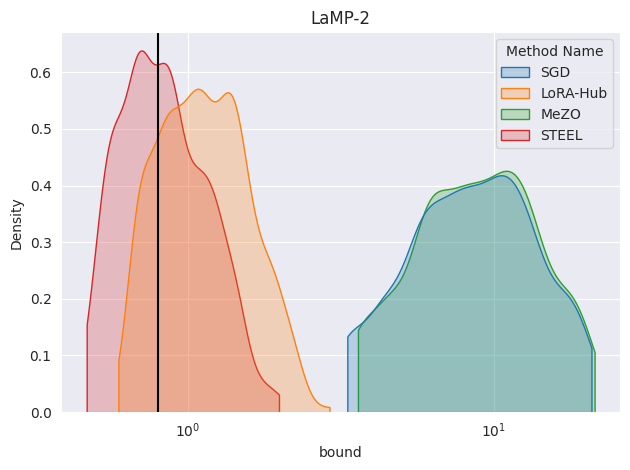

In [269]:

import numpy as np
import seaborn as sns


sns.kdeplot(data=final_results[final_results['Method Name'] != 'Model Zoo'], x="bound", hue="Method Name", legend=True, fill=True, log_scale=True, cut=0)
plt.axvline(0.8, 0, 1, label='Vacuous Bound', color='black')
plt.title(f'LaMP-2')

plt.tight_layout()
plt.savefig('figures/lamp2.svg')
plt.savefig('figures/lamp2.png')
plt.show()


In [10]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.precision', 2)

vacuous_bound = 1-(1/15)

method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]

df = pd.DataFrame(columns=['Method', 'Non-Vacuous Ratio', 'Average Gap (among non-vacuous)', 'Median Gap (among everything)', 'Min Bound', 'Median Bound', 'Max Bound'])
for method_name, method_df in zip(method_names, methods_results):
    metrics = print_bound_stats(method_df, vacuous_bound)
    metrics['Method'] = method_name
    for key, value in metrics.items():
        metrics[key] = [value]
    metrics = pd.DataFrame(metrics)
    df = pd.concat([df, metrics])
print(df.transpose().to_latex(float_format="{:.2f}".format))
df.transpose().head(6)

\begin{tabular}{llllll}
\toprule
 & 0 & 0 & 0 & 0 & 0 \\
\midrule
Method & SGD & LoRA-Hub & MeZO & Model Zoo & STEEL \\
Non-Vacuous Ratio & 0.00 & 32.13 & 0.00 & 70.19 & 65.12 \\
Average Gap (among non-vacuous) & 9.03 & 0.38 & 9.27 & 0.30 & 0.36 \\
Median Gap (among everything) & 8.12 & 0.68 & 8.45 & 0.36 & 0.43 \\
Min Bound & 3.32 & 0.59 & 3.60 & 0.41 & 0.47 \\
Median Bound & 8.52 & 1.12 & 8.85 & 0.75 & 0.80 \\
Max Bound & 20.86 & 2.90 & 21.36 & 1.94 & 1.99 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_577821/2499659356.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, metrics])


,0,0,0,0,0
Method,SGD,LoRA-Hub,MeZO,Model Zoo,STEEL
Non-Vacuous Ratio,0.00,32.13,0.00,70.19,65.12
Average Gap (among non-vacuous),9.03,0.38,9.27,0.30,0.36
Median Gap (among everything),8.12,0.68,8.45,0.36,0.43
Min Bound,3.32,0.59,3.60,0.41,0.47
Median Bound,8.52,1.12,8.85,0.75,0.80


## LaMP-5

In [11]:
data_addr = '/scratch-01/frezk/LaMP/data_raw/user/LaMP_5/dev_questions_merged.json'
with open(data_addr) as f:
    user_data = json.load(f)

#### DIFF

In [12]:
# LAMP-5 DIFF
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-5/dev_questions_merged_stage_4_mlp4x3l_14clusters_trnct_256/per_user'
exp_name = 'model_zoo_14clusters_trnct_256results_user_~.json'

diff_results = get_json_logs_results(user_data, results_dir, exp_name, compute_rouge_1, aggregate_metrics=True, truncate_profile_len=256)
diff_results = compute_zoo_bound(diff_results, N=10000)
print(diff_results['query_acc'].mean())
diff_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 178345
0.47228378961476447


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
1386,1386,256,0.42,0.24,0.58,0.76,0.74,False,-0.03
900,900,256,0.40,0.77,0.60,0.23,0.75,True,0.52
17,17,256,0.60,0.50,0.40,0.50,0.56,True,0.06
1610,1610,256,0.64,0.78,0.36,0.22,0.52,True,0.30
18,18,256,0.48,0.36,0.52,0.64,0.67,True,0.03


#### ZOO

In [13]:
# LAMP-5 MODEL ZOO
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-5/dev_questions_merged_stage_4_model_zoo_54clusters_trnct_256/per_user'
exp_name = 'model_zoo_54clusters_trnct_256results_user_~.json'

model_zoo_results = get_json_logs_results(user_data, results_dir, exp_name, compute_rouge_1, aggregate_metrics=True, truncate_profile_len=256)
model_zoo_results = compute_zoo_bound(model_zoo_results, N=9682)
model_zoo_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 175614


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
1386,1386,256,0.43,0.24,0.57,0.76,0.72,False,-0.04
900,900,256,0.41,0.77,0.59,0.23,0.74,True,0.51
17,17,256,0.60,0.50,0.40,0.50,0.56,True,0.06
1610,1610,256,0.63,0.82,0.37,0.18,0.52,True,0.34
18,18,256,0.48,0.36,0.52,0.64,0.68,True,0.04


#### SGD

In [14]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-5/sgd_baseline_new_recipe/r_6_alpha_16_lr_0.001_epochs_10_sch_linear/per_user'
exp_name = 'user_~.json'

sgd_results = get_json_logs_results(user_data, results_dir, exp_name, compute_rouge_1, support_metric_name='best_support_metric', pred_label_prefix='query_', aggregate_metrics=True)
sgd_results = compute_discretization_bound(sgd_results, N=2592)
print(len(sgd_results))
print(sgd_results['query_acc'].mean())
sgd_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 2500
is list
is list
2500
0.47034738239924245


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
1244,1244,913,0.58,0.50,0.42,0.50,1.61,True,1.11
1732,1732,809,0.57,0.31,0.43,0.69,1.70,True,1.01
1610,1610,767,0.65,0.82,0.35,0.18,1.66,True,1.48
285,285,649,0.59,0.89,0.41,0.11,1.83,True,1.72
130,130,553,0.65,0.70,0.35,0.30,1.89,True,1.58


#### MEZO

In [15]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-5/mezo/r_6_alpha_16_lr_0.001_epochs_320_sch_linear/per_user'
exp_name = 'user_~.json'
mezo_results = get_json_logs_results(user_data, results_dir, exp_name, compute_rouge_1, support_metric_name='best_support_metric', pred_label_prefix='query_', aggregate_metrics=True, truncate_profile_len=256)
mezo_results = compute_discretization_bound(mezo_results, N=2592)
print(len(mezo_results))
print(mezo_results['query_acc'].mean())
mezo_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 2500
is list
is list
2500
0.4703936753348544


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
1386,1386,256,0.44,0.21,0.56,0.79,2.82,True,2.03
900,900,256,0.41,0.77,0.59,0.23,2.85,True,2.62
17,17,256,0.60,0.50,0.40,0.50,2.65,True,2.15
1610,1610,256,0.64,0.82,0.36,0.18,2.62,True,2.44
18,18,256,0.49,0.38,0.51,0.62,2.77,True,2.15


#### LORAHUB

In [16]:
# LAMP-5 LORAHUB
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-5/dev_questions_merged_lora_hub/per_user'
exp_name = 'lora_hubresults_user_~.json'

lorahub_results = get_json_logs_results(user_data, results_dir, exp_name, compute_rouge_1, aggregate_metrics=True, support_metric_name='best_support_metric', truncate_profile_len=256)
lorahub_results = compute_discretization_bound(lorahub_results, N=20)
lorahub_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

total_samples_found 175936


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
1386,1386,256,0.43,0.24,0.57,0.76,0.81,True,0.05
900,900,256,0.40,0.77,0.60,0.23,0.84,True,0.61
17,17,256,0.60,0.50,0.40,0.50,0.64,True,0.14
1610,1610,256,0.64,0.78,0.36,0.22,0.60,True,0.38
18,18,256,0.48,0.38,0.52,0.62,0.76,True,0.14


#### Analysis

In [17]:
method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]

final_results = pd.DataFrame(columns=['Method Name']+sgd_results.columns.to_list())
for method_name, df_results in zip(method_names, methods_results):
    df_results['Method Name'] = method_name
    final_results = pd.concat([final_results, df_results])
lamp5 = final_results.copy()

/tmp/ipykernel_577821/2496100939.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, df_results])


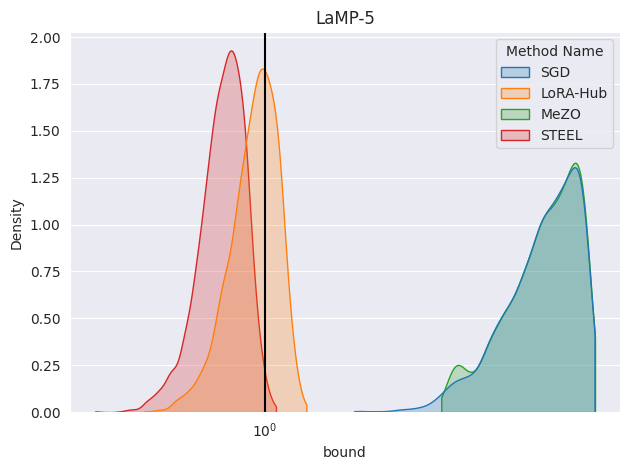

In [21]:
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(1,1)

ax=sns.kdeplot(data=final_results[final_results['Method Name'] != 'Model Zoo'], x="bound", hue="Method Name", legend=True, fill=True, log_scale=True, cut=0, ax=ax)
plt.axvline(1, 0, 1, label='Vacuous Bound', color='black')
plt.title(f'LaMP-5')

fig.tight_layout()
# plt.savefig('figures/lamp5.svg')
# plt.savefig('figures/lamp5.png')
plt.show()

In [22]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.precision', 2)


method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]
vacuous_bound = 1

df = pd.DataFrame(columns=['Method', 'Non-Vacuous Ratio', 'Average Gap (among non-vacuous)', 'Median Gap (among everything)', 'Min Bound', 'Median Bound', 'Max Bound'])
for method_name, method_df in zip(method_names, methods_results):
    metrics = print_bound_stats(method_df, vacuous_bound)
    metrics['Method'] = method_name
    for key, value in metrics.items():
        metrics[key] = [value]
    metrics = pd.DataFrame(metrics)
    df = pd.concat([df, metrics])
print(df.transpose().to_latex(float_format="{:.2f}".format))
df.transpose().head(6)

\begin{tabular}{llllll}
\toprule
 & 0 & 0 & 0 & 0 & 0 \\
\midrule
Method & SGD & LoRA-Hub & MeZO & Model Zoo & STEEL \\
Non-Vacuous Ratio & 0.00 & 63.84 & 0.00 & 99.24 & 99.16 \\
Average Gap (among non-vacuous) & 3.95 & 0.38 & 3.96 & 0.28 & 0.28 \\
Median Gap (among everything) & 4.04 & 0.41 & 4.04 & 0.26 & 0.26 \\
Min Bound & 1.61 & 0.52 & 2.58 & 0.41 & 0.40 \\
Median Bound & 4.57 & 0.96 & 4.57 & 0.81 & 0.81 \\
Max Bound & 5.86 & 1.25 & 5.88 & 1.05 & 1.06 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_577821/476847187.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, metrics])


,0,0,0,0,0
Method,SGD,LoRA-Hub,MeZO,Model Zoo,STEEL
Non-Vacuous Ratio,0.00,63.84,0.00,99.24,99.16
Average Gap (among non-vacuous),3.95,0.38,3.96,0.28,0.28
Median Gap (among everything),4.04,0.41,4.04,0.26,0.26
Min Bound,1.61,0.52,2.58,0.41,0.40
Median Bound,4.57,0.96,4.57,0.81,0.81


## LaMP-3

In [23]:
# Collect results
def get_json_logs_results_lamp3(user_data, results_dir, exp_name, truncate_profile_len=None):
    support_size = []
    support_metrics = []
    query_metrics = []
    user_ids = []

    for i, user in tqdm(enumerate(user_data)):
        user_ids.append(i)
        # get support size
        profile_len = len(user['profile'])
        # truncate if necessary
        if truncate_profile_len is not None and profile_len > truncate_profile_len:
            profile_len = truncate_profile_len
        support_size.append(profile_len)
        # get user results
        user_reults_file = os.path.join(results_dir, exp_name.replace('~', str(i)))
        with open(user_reults_file) as f:
            user_results = json.load(f)
        support_metrics.append(user_results['support_metric'])
        query_metrics.append(user_results['query_metric'])
    
    df = pd.DataFrame({
        'user_id': user_ids,
        'support_size':support_size,
        'support_acc': support_metrics,
        'query_acc': query_metrics
    }).sort_values('support_size')
    return df


In [24]:
data_addr = '/scratch-01/frezk/LaMP/data_raw/user/LaMP_3/dev_questions_merged.json'
with open(data_addr) as f:
    user_data = json.load(f)

#### DIFF

In [25]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-3/dev_questions_merged_stage_4_mlp4x3l_92clusters_trnct_256/per_user_cross_entropy'
exp_name = 'user_~.json'

diff_results = get_json_logs_results_lamp3(user_data, results_dir, exp_name, truncate_profile_len=256)
diff_results = compute_zoo_bound(diff_results, N=10000, revert_acc=False)
diff_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
686,686,256,0.77,0.13,0.77,0.13,0.93,True,0.79
2408,2408,256,0.78,0.96,0.78,0.96,0.93,False,-0.03
951,951,256,0.68,0.72,0.68,0.72,0.84,True,0.12
579,579,256,0.70,0.42,0.70,0.42,0.85,True,0.43
2365,2365,256,0.74,0.82,0.74,0.82,0.90,True,0.08


#### ZOO

In [26]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-3/dev_questions_merged_stage_4_model_zoo_150clusters_trnct_256/per_user_cross_entropy'
exp_name = 'user_~.json'

model_zoo_results = get_json_logs_results_lamp3(user_data, results_dir, exp_name, truncate_profile_len=256)
model_zoo_results = compute_zoo_bound(model_zoo_results, N=20000, revert_acc=False)
model_zoo_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
686,686,256,0.72,0.04,0.72,0.04,0.88,True,0.84
2408,2408,256,0.90,0.88,0.90,0.88,1.06,True,0.18
951,951,256,0.60,0.04,0.60,0.04,0.76,True,0.73
579,579,256,0.78,0.91,0.78,0.91,0.94,True,0.04
2365,2365,256,0.71,0.91,0.71,0.91,0.87,False,-0.04


#### MEZO

In [27]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-3/mezo/r_6_alpha_16_lr_0.001_epochs_320_sch_linear/per_user_cross_entropy'
exp_name = 'user_~.json'

mezo_results = get_json_logs_results_lamp3(user_data, results_dir, exp_name, truncate_profile_len=256)
mezo_results = compute_discretization_bound(mezo_results, N=2592, revert_acc=False)
print('log results:', mezo_results['query_acc'].mean())
mezo_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

log results: 0.6223019418641925


,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
686,686,256,0.70,0.20,0.70,0.20,2.96,True,2.76
2408,2408,256,0.79,0.89,0.79,0.89,3.04,True,2.15
951,951,256,0.66,0.43,0.66,0.43,2.92,True,2.49
579,579,256,0.64,0.69,0.64,0.69,2.90,True,2.21
2365,2365,256,0.67,0.66,0.67,0.66,2.93,True,2.27


#### SGD

In [28]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-3/sgd_baseline_new_recipe/r_6_alpha_16_lr_0.01_epochs_10_sch_linear/per_user_cross_entropy'
exp_name = 'user_~.json'
sgd_results = get_json_logs_results_lamp3(user_data, results_dir, exp_name)
sgd_results = compute_discretization_bound(sgd_results, N=2592, revert_acc=False)
sgd_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
13,13,1023,0.69,0.72,0.69,0.72,1.82,True,1.11
1204,1204,996,0.69,0.87,0.69,0.87,1.83,True,0.97
1572,1572,983,0.50,0.43,0.50,0.43,1.65,True,1.22
1675,1675,964,0.88,0.98,0.88,0.98,2.05,True,1.07
1796,1796,961,0.24,0.01,0.24,0.01,1.40,True,1.39


#### LORA-HUB

In [29]:
results_dir = '/scratch-01/frezk/LaMP/experiments/LaMP-3/dev_questions_merged_lora_hub_trnct_256_seeded/per_user_cross_entropy'
exp_name = 'user_~.json'

lorahub_results = get_json_logs_results_lamp3(user_data, results_dir, exp_name)
lorahub_results = compute_discretization_bound(lorahub_results, N=20, revert_acc=False)
lorahub_results.sort_values('support_size', ascending=False).head()

0it [00:00, ?it/s]

,user_id,support_size,support_acc,query_acc,support_err,query_err,bound,bound_faithful,gap
13,13,1023,0.92,1.00,0.92,1.00,1.04,True,0.04
1204,1204,996,0.63,0.64,0.63,0.64,0.75,True,0.11
1572,1572,983,0.79,0.40,0.79,0.40,0.92,True,0.51
1675,1675,964,0.82,0.93,0.82,0.93,0.95,True,0.01
1796,1796,961,0.69,0.80,0.69,0.80,0.81,True,0.01


#### Analysis

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")
palette = sns.color_palette("tab10")

vacuous_bound = 1-(1/15)

method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]

final_results = pd.DataFrame(columns=['Method Name']+sgd_results.columns.to_list())
for method_name, df_results in zip(method_names, methods_results):
    df_results['Method Name'] = method_name
    final_results = pd.concat([final_results, df_results])
lamp3=final_results.copy()

/tmp/ipykernel_577821/4030132408.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, df_results])


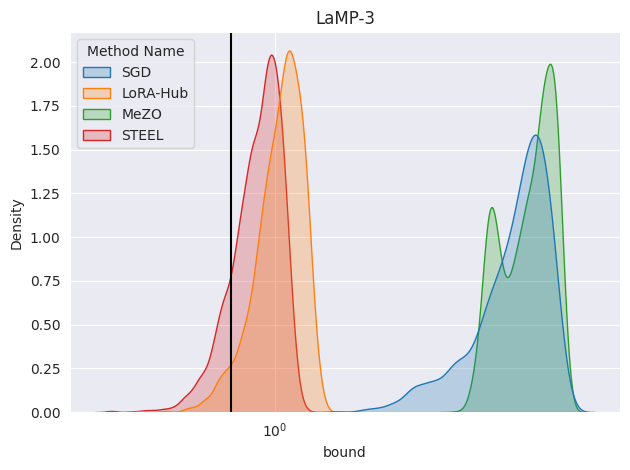

In [35]:
import numpy as np
import seaborn as sns


sns.kdeplot(data=final_results[final_results['Method Name'] != 'Model Zoo'], x="bound", hue="Method Name", legend=True, fill=True, log_scale=True)
plt.axvline(1-(1/5), 0, 1, label='Vacuous Bound', color='black')
plt.title(f'LaMP-3')

plt.tight_layout()
# plt.savefig('figures/lamp3.svg')
# plt.savefig('figures/lamp3.png')
plt.show()


In [33]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.precision', 2)

vacuous_bound = 1-(1/5)

method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]

df = pd.DataFrame(columns=['Method', 'Non-Vacuous Ratio', 'Average Gap (among non-vacuous)', 'Median Gap (among everything)', 'Min Bound', 'Median Bound', 'Max Bound'])
for method_name, method_df in zip(method_names, methods_results):
    metrics = print_bound_stats(method_df, vacuous_bound)
    metrics['Method'] = method_name
    for key, value in metrics.items():
        metrics[key] = [value]
    metrics = pd.DataFrame(metrics)
    df = pd.concat([df, metrics])
print(df.transpose().to_latex(float_format="{:.2f}".format))
df.transpose().head(6)

\begin{tabular}{llllll}
\toprule
 & 0 & 0 & 0 & 0 & 0 \\
\midrule
Method & SGD & LoRA-Hub & MeZO & Model Zoo & STEEL \\
Non-Vacuous Ratio & 0.00 & 5.00 & 0.00 & 7.16 & 15.48 \\
Average Gap (among non-vacuous) & 2.98 & 0.25 & 3.06 & 0.25 & 0.26 \\
Median Gap (among everything) & 3.09 & 0.23 & 3.10 & 0.13 & 0.14 \\
Min Bound & 1.35 & 0.51 & 2.54 & 0.55 & 0.43 \\
Median Bound & 3.56 & 1.04 & 3.76 & 0.97 & 0.93 \\
Max Bound & 4.57 & 1.30 & 4.53 & 1.18 & 1.17 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_577821/1172502659.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, metrics])


,0,0,0,0,0
Method,SGD,LoRA-Hub,MeZO,Model Zoo,STEEL
Non-Vacuous Ratio,0.00,5.00,0.00,7.16,15.48
Average Gap (among non-vacuous),2.98,0.25,3.06,0.25,0.26
Median Gap (among everything),3.09,0.23,3.10,0.13,0.14
Min Bound,1.35,0.51,2.54,0.55,0.43
Median Bound,3.56,1.04,3.76,0.97,0.93


In [34]:
method_names = ['SGD', 'LoRA-Hub', 'MeZO', 'Model Zoo', 'STEEL']
methods_results = [sgd_results, lorahub_results , mezo_results, model_zoo_results, diff_results]

for method_name, method_results_df in zip(method_names, methods_results):
    print('#'*10, method_name)
    cross_entropy = method_results_df['support_size']*method_results_df['query_acc']
    print(cross_entropy.sum()/method_results_df['support_size'].sum())

########## SGD
0.47919660435158445
########## LoRA-Hub
0.7397819031272198
########## MeZO
0.62670426847263
########## Model Zoo
0.7489702342407337
########## STEEL
0.693296430204814


# Final Visualization

FileNotFoundError: [Errno 2] No such file or directory: 'figures/lamp_bound_dist.svg'

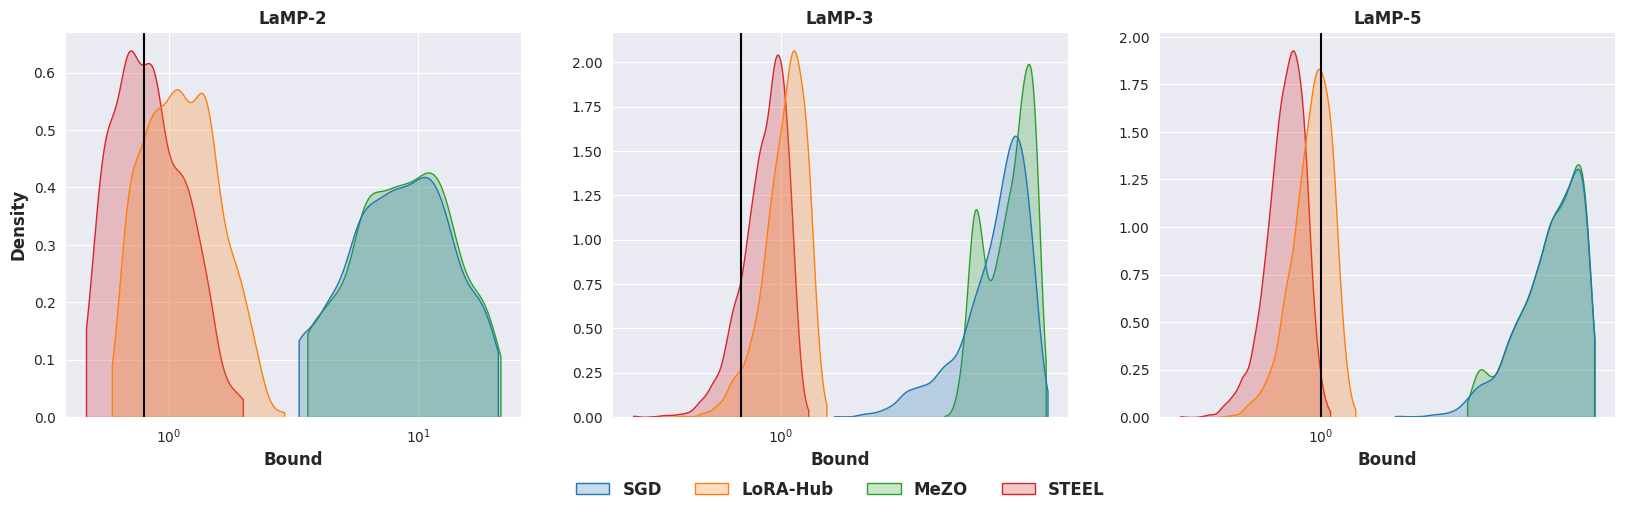

In [36]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(20,5))

# LaMP-2
sns.kdeplot(data=lamp2[lamp2['Method Name'] != 'Model Zoo'], x="bound", hue="Method Name", legend=True, fill=True, log_scale=True, cut=0, ax=ax[0])
ax[0].axvline(0.8, 0, 1, label='Vacuous Bound', color='black')
ax[0].set_title(f'LaMP-2', fontweight='bold', fontsize=12)
ax[0].set_xlabel('Bound', fontweight='bold', fontsize=12)
ax[0].set_ylabel('Density', fontweight='bold', fontsize=12)

lgd = sns.move_legend(ax[0], loc='lower center', bbox_to_anchor=(1.7,-0.25), ncol=4, frameon=False, title=None, prop={'size': 12, 'weight':'bold'})

#LaMP-3
sns.kdeplot(data=lamp3[lamp3['Method Name'] != 'Model Zoo'], x="bound", hue="Method Name", fill=True, log_scale=True, cut=0, ax=ax[1])
ax[1].axvline(1-(1/5), 0, 1, label='Vacuous Bound', color='black')
ax[1].set_title(f'LaMP-3', fontweight='bold', fontsize=12)
ax[1].get_legend().remove()
ax[1].set_xlabel('Bound', fontweight='bold', fontsize=12)
ax[1].set_ylabel('', fontweight='bold', fontsize=12)


#LaMP-5
sns.kdeplot(data=lamp5[lamp5['Method Name'] != 'Model Zoo'], x="bound", hue="Method Name", fill=True, log_scale=True, cut=0, ax=ax[2])
ax[2].axvline(1, 0, 1, label='Vacuous Bound', color='black')
ax[2].set_title(f'LaMP-5', fontweight='bold', fontsize=12)
ax[2].get_legend().remove()
ax[2].set_xlabel('Bound', fontweight='bold', fontsize=12)
ax[2].set_ylabel('', fontweight='bold', fontsize=12)

# plt.savefig('figures/lamp_bound_dist.svg', bbox_inches='tight')
# plt.savefig('figures/lamp_bound_dist.png', bbox_inches='tight')
plt.show()